In [25]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [26]:
data = pd.read_table('data/2018-E-c-En-train.txt')

In [27]:
print(data.head())

              ID                                              Tweet  anger  \
0  2017-En-21441  “Worry is a down payment on a problem you may ...      0   
1  2017-En-31535  Whatever you decide to do make sure it makes y...      0   
2  2017-En-21068  @Max_Kellerman  it also helps that the majorit...      1   
3  2017-En-31436  Accept the challenges so that you can literall...      0   
4  2017-En-22195  My roommate: it's okay that we can't spell bec...      1   

   anticipation  disgust  fear  joy  love  optimism  pessimism  sadness  \
0             1        0     0    0     0         1          0        0   
1             0        0     0    1     1         1          0        0   
2             0        1     0    1     0         1          0        0   
3             0        0     0    1     0         1          0        0   
4             0        1     0    0     0         0          0        0   

   surprise  trust  
0         0      1  
1         0      0  
2         0      

In [28]:
categories = list(data.columns.values)

In [29]:
print(categories)

['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']


In [30]:
data.iloc[:,2:].sum().values

array([2544,  978, 2602, 1242, 2477,  700, 1984,  795, 2008,  361,  357])

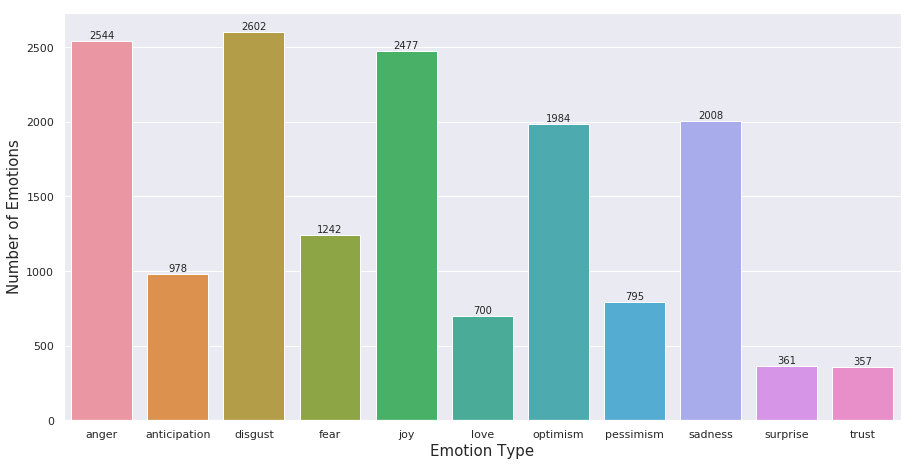

In [31]:
sns.set(font_scale = 1)
plt.figure(figsize = (15,7.5))
plt.ylabel("Number of Emotions", fontsize = 15)
plt.xlabel("Emotion Type", fontsize = 15)
ax = sns.barplot(categories[2:], data.iloc[:,2:].sum().values)
rects = ax.patches
labels = data.iloc[:,2:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height +5, label,
           ha = 'center', va = 'bottom', fontsize =10)
plt.show()


In [32]:
rowsums = data.iloc[:,2:].sum(axis =1)

In [33]:
print(rowsums.head())

0    3
1    3
2    4
3    2
4    2
dtype: int64


In [34]:
multilabel_counts = rowsums.value_counts()

In [35]:
multilabel_counts = multilabel_counts.sort_index() # revise a little

In [36]:
multilabel_counts.index

Int64Index([0, 1, 2, 3, 4, 5, 6], dtype='int64')

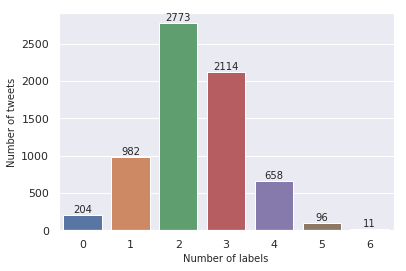

In [37]:
ax = sns.barplot(multilabel_counts.index, multilabel_counts.values)
plt.ylabel('Number of tweets', fontsize = 10)
plt.xlabel('Number of labels', fontsize = 10) 
rects = ax.patches
labels = multilabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height +5, label,
           ha = 'center', va = 'bottom', fontsize =10)
plt.show()

In [38]:
tweets = data.Tweet

In [39]:
from wordcloud import WordCloud, STOPWORDS

In [40]:
text = tweets.values

In [41]:
cloud = WordCloud(stopwords = STOPWORDS,
                 background_color = 'black',
                 collocations = False,
                 width = 2500,
                 height = 1800).generate(" ".join(text))

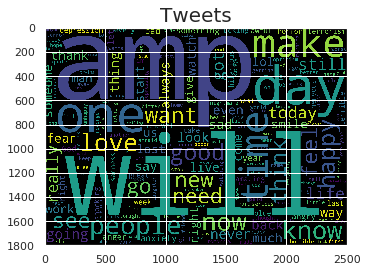

In [42]:
plt.title("Tweets",fontsize = 20)
plt.imshow(cloud)

In [43]:
data.columns

Index(['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy',
       'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
      dtype='object')

In [44]:
data.shape

(6838, 13)

In [45]:
# drop any rows that have "na"
df1 = data.dropna(how="any")

In [46]:
df1.shape # there is no na data 

(6838, 13)

### One vs Rest methodology 

In [47]:
train_data = pd.read_table('data/2018-E-c-En-train.txt')

In [48]:
dev_data = pd.read_table('data/2018-E-c-En-dev.txt')

In [49]:
train_text = train_data.Tweet

In [50]:
dev_text = dev_data.Tweet

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(strip_accents = "unicode", analyzer = "word", ngram_range = (1,3), norm = "l2")
vectorizer.fit(train_text)
vectorizer.fit(dev_text)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents='unicode', sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [52]:
x_train = vectorizer.transform(train_text)
y_train = train_data.drop(labels = ["ID", "Tweet"], axis = 1)

x_dev = vectorizer.transform(dev_text)
y_dev = dev_data.drop(labels = ["ID", "Tweet"], axis = 1)

In [53]:
vocab = vectorizer.vocabulary_# {feature name: feature index}

In [54]:
vocab = {i:v for v,i in vocab.items()}

In [55]:
len(vocab)

26114

Logistic Regression baseline

In [57]:
# confusion matrix on training set
def stats_report(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    precision = tp/(tp + fp)
    recall = tp/(tp + fn)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_micro = f1_score(y_true, y_pred, average = "micro")
    f1 = f1_score(y_true, y_pred)
    print("Precision: {} \n Recall: {} \n F1 macro: {} \n F1 micro: {} \n F1: {} \n".format(precision, recall, f1_macro, f1_micro, f1))

In [58]:
LogReg_pipeline = Pipeline([
    ('clf', OneVsRestClassifier(LogisticRegression(solver = 'sag'), n_jobs = -1)),])
categories = categories[2:]
for category in categories:
    LogReg_pipeline.fit(x_train, y_train[category])
    print("Processing {} tweets ".format(category))
    prediction = LogReg_pipeline.predict(x_train)
    stats_report(y_train[category], prediction)
    print("Accuracy on training set is {}".format(accuracy_score(y_train[category], prediction)))
    prediction_dev = LogReg_pipeline.predict(x_dev)
    print("Accuracy on dev set is {} \n".format(accuracy_score(y_dev[category], prediction_dev)))

Processing disgust tweets 
Precision: 0.8769309989701339 
 Recall: 0.6544965411222137 
 F1 macro: 0.8124715633926203 
 F1 micro: 0.8335770693185142 
 F1: 0.7495598591549296 

Accuracy on training set is 0.8335770693185142
Accuracy on dev set is 0.6839729119638827 

Processing fear tweets 
Precision: 0.973404255319149 
 Recall: 0.4420289855072464 
 F1 macro: 0.7741636275599167 
 F1 micro: 0.8964609534951741 
 F1: 0.6079734219269103 

Accuracy on training set is 0.8964609534951741
Accuracy on dev set is 0.8702031602708804 

Processing joy tweets 
Precision: 0.9312573443008225 
 Recall: 0.6398869600322972 
 F1 macro: 0.8261553005378482 
 F1 micro: 0.8524422345715121 
 F1: 0.7585546781526681 

Accuracy on training set is 0.8524422345715121
Accuracy on dev set is 0.6715575620767494 

Processing love tweets 
Precision: 0.9384615384615385 
 Recall: 0.1742857142857143 
 F1 macro: 0.6241792954161344 
 F1 micro: 0.9143024276104124 
 F1: 0.2939759036144578 

Accuracy on training set is 0.91430242

Since the data set is imbalancd, we propose different metrics to evaluate our model:
Precision
Recall
Micro F1
Macro F1

In [59]:
for category in categories:
    LogReg_pipeline.fit(x_train, y_train[category])
    print("Processing {} tweets ".format(category))
    prediction = LogReg_pipeline.predict(x_train)
    stats_report(y_train[category], prediction)
    prediction_dev = LogReg_pipeline.predict(x_dev)
    stats_report(y_dev[category], prediction_dev)


Processing disgust tweets 
Precision: 0.8769309989701339 
 Recall: 0.6544965411222137 
 F1 macro: 0.8124715633926203 
 F1 micro: 0.8335770693185142 
 F1: 0.7495598591549296 

Precision: 0.8679245283018868 
 Recall: 0.14420062695924765 
 F1 macro: 0.5236559139784946 
 F1 micro: 0.6839729119638827 
 F1: 0.24731182795698925 

Processing fear tweets 
Precision: 0.973404255319149 
 Recall: 0.4420289855072464 
 F1 macro: 0.7741636275599167 
 F1 micro: 0.8964609534951741 
 F1: 0.6079734219269103 

Precision: 1.0 
 Recall: 0.049586776859504134 
 F1 macro: 0.5122896871933562 
 F1 micro: 0.8702031602708804 
 F1: 0.09448818897637795 

Processing joy tweets 
Precision: 0.9312573443008225 
 Recall: 0.6398869600322972 
 F1 macro: 0.8261553005378482 
 F1 micro: 0.8524422345715121 
 F1: 0.7585546781526681 

Precision: 0.957983193277311 
 Recall: 0.285 
 F1 macro: 0.6035318703320124 
 F1 micro: 0.6715575620767494 
 F1: 0.4393063583815028 

Processing love tweets 
Precision: 0.9384615384615385 
 Recall:

In [60]:
# random_forest pipeline
RF_pipeline = Pipeline([('rf', OneVsRestClassifier(RandomForestClassifier(n_estimators = 300,
                                                                        max_depth = 5,
                                                                       random_state = 0))),])


In [61]:
for category in categories:
    RF_pipeline.fit(x_train, y_train[category])
    print("Processing {} tweets ".format(category))
    prediction = RF_pipeline.predict(x_train)
    stats_report(y_train[category], prediction)
    prediction_dev = RF_pipeline.predict(x_dev)
    stats_report(y_dev[category], prediction_dev)

Processing disgust tweets 
Precision: nan 
 Recall: 0.0 
 F1 macro: 0.3825176088134369 
 F1 micro: 0.6194793799356537 
 F1: 0.0 

Precision: nan 
 Recall: 0.0 
 F1 macro: 0.3902271163110805 
 F1 micro: 0.6399548532731377 
 F1: 0.0 

Processing fear tweets 
Precision: nan 
 Recall: 0.0 
 F1 macro: 0.4500562972494772 
 F1 micro: 0.818367943843229 
 F1: 0.0 

Precision: nan 
 Recall: 0.0 
 F1 macro: 0.46335554209569957 
 F1 micro: 0.863431151241535 
 F1: 0.0 

Processing joy tweets 
Precision: nan 
 Recall: 0.0 
 F1 macro: 0.38940976872935085 
 F1 micro: 0.6377595788242176 
 F1: 0.0 

Precision: nan 
 Recall: 0.0 
 F1 macro: 0.35422740524781343 
 F1 micro: 0.5485327313769752 
 F1: 0.0 

Processing love tweets 
Precision: nan 
 Recall: 0.0 
 F1 macro: 0.47302712700369914 
 F1 micro: 0.897630886224042 
 F1: 0.0 

Precision: nan 
 Recall: 0.0 
 F1 macro: 0.45975609756097563 
 F1 micro: 0.8510158013544018 
 F1: 0.0 

Processing optimism tweets 
Precision: nan 
 Recall: 0.0 
 F1 macro: 0.41515

In [63]:
from IPython.display import Image 
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.externals.six import StringIO  

In [64]:
dot_data = StringIO()

In [65]:
# inspect anger vs rest

category = "anger"
RF_pipeline.fit(x_train, y_train[category])

Pipeline(memory=None,
     steps=[('rf', OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
          n_jobs=None))])

In [66]:
forest = RF_pipeline.named_steps['rf'].estimators_[0].estimators_ #300 trees(parameter)

In [67]:
# pull no.5 tree from forest
pull_a_tree = forest[5]

In [68]:
# get feature importance
importances = pull_a_tree.feature_importances_
sorted_importances = sorted(range(len(importances)), key = lambda k:importances[k], reverse = True)


In [69]:
# only fetch first 100 features
important_features = sorted_importances[0:50]
for i in important_features:
        
    print("{}:{}".format(vocab[i],importances[i]))

cops:0.20913392920831167
so angry:0.18922546521363012
had to:0.18488847709497733
at all:0.17341709134901634
and all:0.11063431248693117
after:0.08563928471988186
find:0.03159248284609586
done:0.007699096449562448
bit:0.002976983960497512
and it:0.0029617952668214943
facts:0.0009872650889405053
hear:0.0003525946746215956
shake:0.0002742403024834788
in my:0.0002169813382287059
00:0.0
00 only:0.0
00 only to:0.0
000:0.0
000 new:0.0
000 new us:0.0
000 years:0.0
000 years ago:0.0
01:0.0
01 september:0.0
01 september excited:0.0
05:0.0
05 30:0.0
05 30 is:0.0
0510keisuke:0.0
0510keisuke devour:0.0
0510keisuke devour the:0.0
07:0.0
07 11:0.0
07 11 19:0.0
0liviarobertson:0.0
0liviarobertson poor:0.0
0liviarobertson poor lyn:0.0
10:0.0
10 free:0.0
10 free lyfts:0.0
10 horror:0.0
10 horror was:0.0
10 pma:0.0
100:0.0
100 off:0.0
100 off 42:0.0
1000s:0.0
1000s came:0.0
1000s came in:0.0
100daysofcode:0.0


In [70]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

export_graphviz(pull_a_tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)



^
Expected {'graph' | 'digraph'} (at char 0), (line:1, col:1)


In [71]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

InvocationException: GraphViz's executables not found

In this step, I will pull all trees from the forest and extract all non-zero features.

In [ ]:
all_important_features = set()
for tree in forest:
    f_importance = np.array(tree.feature_importances_)
    # sorted indices
    sort_f_indices = sorted(range(len(f_importance)), key = lambda k: f_importance[k], reverse = True)
    sort_f_importance = f_importance[sort_f_indices]
    # non_zero importance
    non_zero_sort_f_importance = [x for x in sort_f_importance if x]
    non_zero_sort_f_indices = sort_f_indices[:len(non_zero_sort_f_importance)]
    for i in non_zero_sort_f_indices:
        feature = vocab[i]
        all_important_features.add(feature)

In [ ]:
list(all_important_features)[:5]

In [ ]:
len(all_important_features)